# Chicago Housing Model

## Models selected

- Linear regression (baseline)

- Gradient-boosting decision tree, [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgbm


# Processing dataset

,Land Square Feet,Building Square Feet,Rooms,Bedrooms,Full Baths,Garage 1 Size,Garage 2 Size,Age,Population,EKW_2024,INC_2019-2023,CZM_2023,EDB_2019-2023,Sale Price,residence_type_1.0,residence_type_2.0,residence_type_3.0,residence_type_4.0,residence_type_5.0
0,4500.0,7435.0,24.0,12.0,6.0,2.0,0.0,87,5101.0,14.13,36681.0,473.0,86.393773,79000,False,False,True,False,False
1,3720.0,4287.0,9.0,5.0,4.0,2.5,0.0,4,3091.0,16.92,212677.0,124.0,100.000000,3705000,False,False,True,False,False
2,7560.0,2538.0,6.0,5.0,2.0,1.0,0.0,62,2928.0,14.89,79896.0,45.0,89.829728,560000,True,False,False,False,False
3,4750.0,1673.0,5.0,2.0,2.0,0.0,0.0,74,3831.0,15.83,102094.0,163.0,87.607638,318000,False,False,False,False,True
5,4687.0,2090.0,11.0,4.0,2.0,2.0,0.0,92,4693.0,14.79,63523.0,494.0,96.694215,63000,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186046,3720.0,1510.0,9.0,5.0,1.0,1.0,0.0,65,5348.0,15.20,122652.0,104.0,94.859813,279500,False,False,False,False,True
186047,5406.0,2892.0,9.0,4.0,2.0,0.0,0.0,110,2922.0,15.00,73041.0,141.0,91.180524,1169000,False,True,False,False,False
186048,4000.0,1512.0,7.0,4.0,1.0,2.0,0.0,65,5424.0,12.39,43986.0,315.0,86.263591,65000,False,False,False,False,True
186050,2750.0,2142.0,10.0,5.0,2.0,0.0,0.0,120,3621.0,13.67,27012.0,227.0,91.807591,77500,False,True,False,False,False


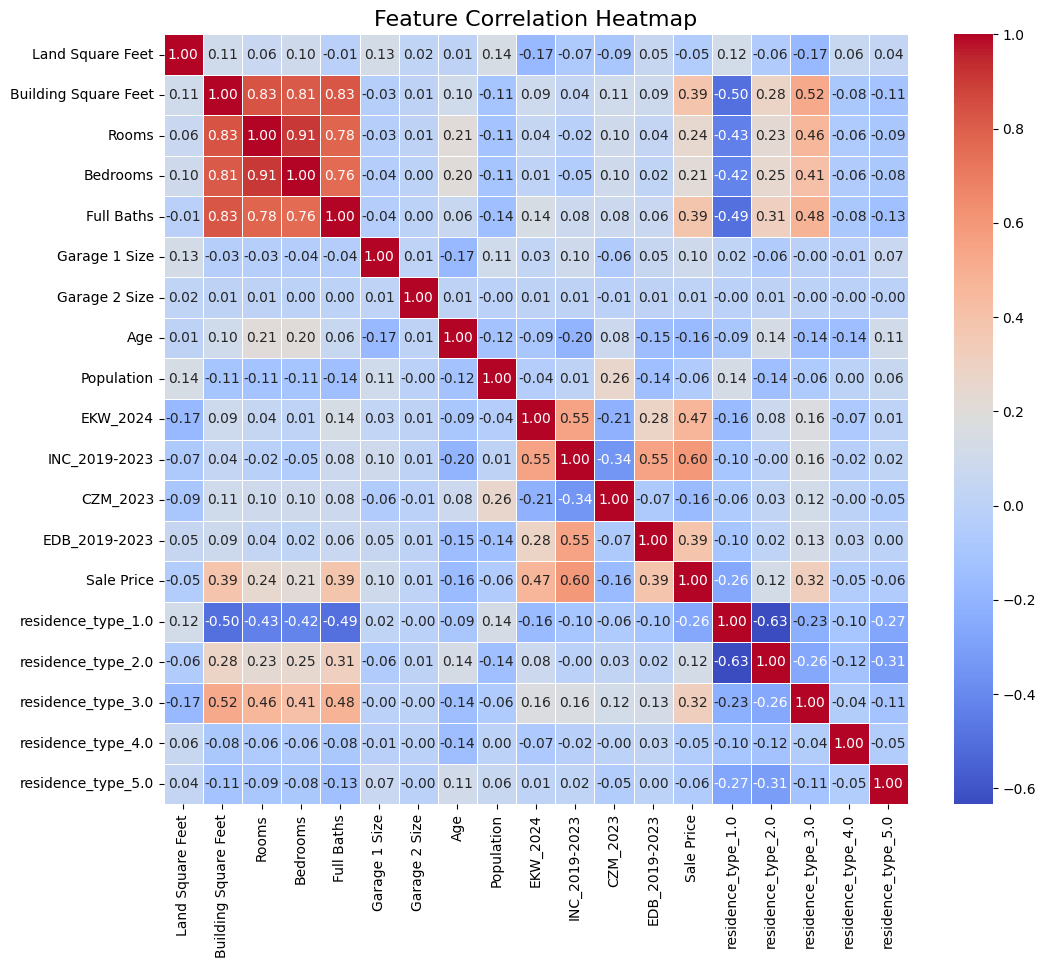

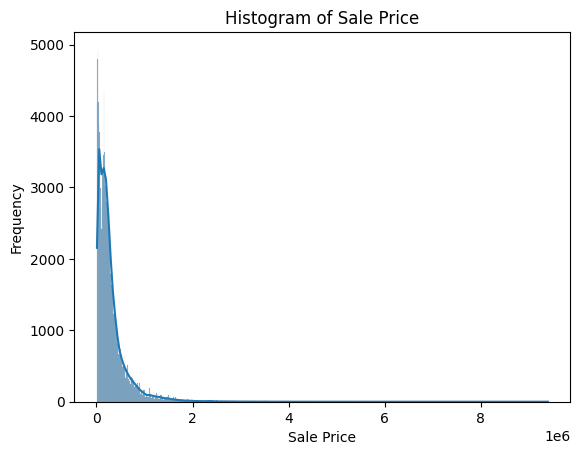

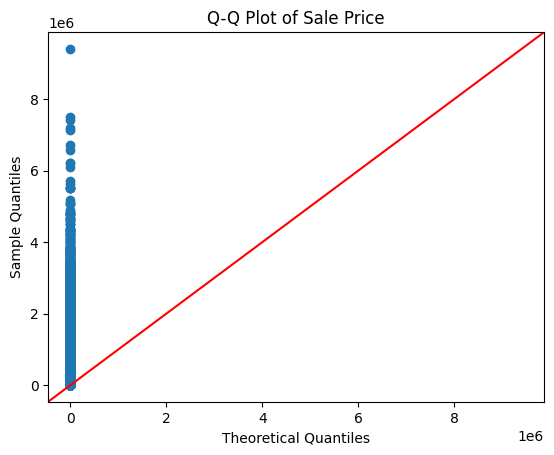

In [114]:
fp_dataset = '../datasets/chicago_housing_data.csv'
df = pd.read_csv(fp_dataset)

# target features
target_cols = [
    'Type of Residence',
    'Land Square Feet',
    'Building Square Feet',
    'Rooms', 
    'Bedrooms',
    'Full Baths',
    'Garage 1 Size',
    'Garage 2 Size',
    'Age',
    'Population', 
    'EKW_2024', 
    'INC_2019-2023', 
    'CZM_2023', 
    'EDB_2019-2023',
    'Sale Price']

df.drop(df.loc[df['Pure Market Filter'] == 0].index, inplace=True)  # filtering to pure market
df = df[target_cols]

garage_map = {
    0: 0,
    1: 1,
    2: 1.5,
    3: 2,
    4: 2.5,
    5: 3,
    6: 3.5,
    7: 0,
    8: 4
}

df = pd.get_dummies(df, columns=['Type of Residence'], prefix='residence_type')

# converting the column to its actual size values
df['Garage 1 Size'] = df['Garage 1 Size'].astype(int).map(garage_map)
df['Garage 2 Size'] = df['Garage 2 Size'].astype(int).map(garage_map)

display(df)

# Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

# Plot the histogram and KDE for Sale Price
sns.histplot(df['Sale Price'], kde=True)
plt.title('Histogram of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

sm.qqplot(df['Sale Price'], line='45')
plt.title('Q-Q Plot of Sale Price')
plt.show()


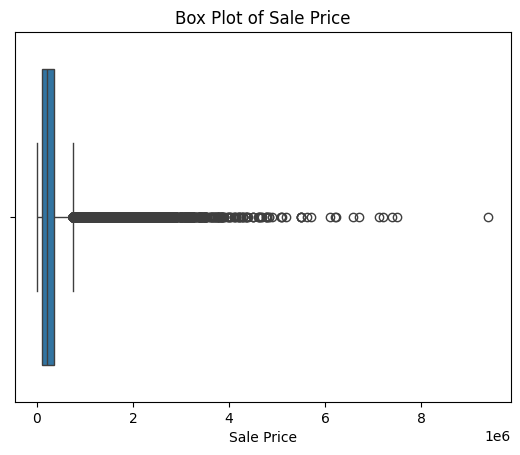

Number of outliers in Sale Price: 9785


In [115]:
sns.boxplot(x=df['Sale Price'])
plt.title('Box Plot of Sale Price')
plt.show()

# Calculate the first (Q1) and third (Q3) quartiles for Sale Price
Q1 = df['Sale Price'].quantile(0.25)
Q3 = df['Sale Price'].quantile(0.75)

median = df['Sale Price'].quantile()

IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Sale Price'] < lower_bound) | (df['Sale Price'] > upper_bound)]
print("Number of outliers in Sale Price:", outliers.shape[0])

# Removing it
df = df[(df['Sale Price'] >= lower_bound) & (df['Sale Price'] <= upper_bound)]


# Transforming 'Sale Price' into log value

## SKIP THIS!! RMSE was worse on both and really does nothing

In [116]:
# # Calculate skewness
# sale_price_skew = df['Sale Price'].skew()
# print("Skewness of Sale Price:", sale_price_skew)

# # Apply a log transformation (using log1p in case there are zeros)
# df['Sale Price_transformed'] = np.log1p(df['Sale Price'])

# # Drop untransformed sale price
# df = df.drop('Sale Price', axis=1)

# # Visualize the transformed data
# sns.histplot(df['Sale Price_transformed'], kde=True)
# plt.title('Histogram of Log-Transformed Sale Price')
# plt.xlabel('Log-transformed Sale Price')
# plt.ylabel('Frequency')
# plt.show()

# # Calculate skewness of the transformed data
# transformed_skew = df['Sale Price_transformed'].skew()
# print("Skewness of log-transformed Sale Price:", transformed_skew)

# # Heatmap now
# plt.figure(figsize=(12, 10))
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
# plt.title('Feature Correlation Heatmap', fontsize=16)
# plt.show()


## Further trimming of features

,Land Square Feet,Building Square Feet,Rooms,Bedrooms,Full Baths,Garage 1 Size,Garage 2 Size,Age,EKW_2024,INC_2019-2023,CZM_2023,EDB_2019-2023,Sale Price,residence_type_1.0,residence_type_2.0,residence_type_3.0,residence_type_4.0,residence_type_5.0
0,4500.0,7435.0,24.0,12.0,6.0,2.0,0.0,87,14.13,36681.0,473.0,86.393773,79000,False,False,True,False,False
2,7560.0,2538.0,6.0,5.0,2.0,1.0,0.0,62,14.89,79896.0,45.0,89.829728,560000,True,False,False,False,False
3,4750.0,1673.0,5.0,2.0,2.0,0.0,0.0,74,15.83,102094.0,163.0,87.607638,318000,False,False,False,False,True
5,4687.0,2090.0,11.0,4.0,2.0,2.0,0.0,92,14.79,63523.0,494.0,96.694215,63000,False,True,False,False,False
7,6936.0,1384.0,6.0,3.0,1.0,0.0,0.0,58,14.89,117583.0,82.0,90.208817,170400,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186045,3125.0,1338.0,7.0,3.0,1.0,1.0,0.0,139,14.88,33994.0,202.0,76.246719,154500,False,False,False,False,True
186046,3720.0,1510.0,9.0,5.0,1.0,1.0,0.0,65,15.20,122652.0,104.0,94.859813,279500,False,False,False,False,True
186048,4000.0,1512.0,7.0,4.0,1.0,2.0,0.0,65,12.39,43986.0,315.0,86.263591,65000,False,False,False,False,True
186050,2750.0,2142.0,10.0,5.0,2.0,0.0,0.0,120,13.67,27012.0,227.0,91.807591,77500,False,True,False,False,False


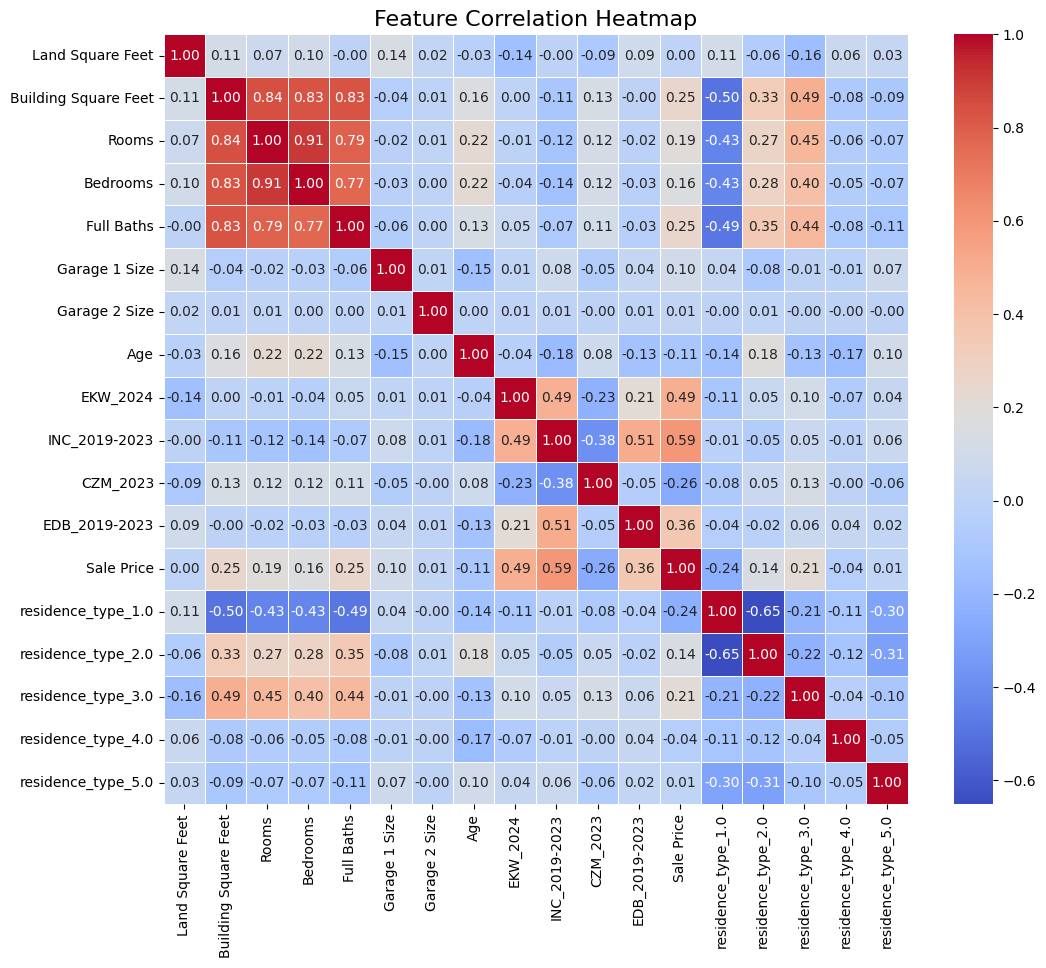

Top correlated features with 'Sale Price':
 Sale Price              1.000000
INC_2019-2023           0.594793
EKW_2024                0.492262
EDB_2019-2023           0.359092
CZM_2023                0.259402
Full Baths              0.248508
Building Square Feet    0.246169
residence_type_1.0      0.240766
residence_type_3.0      0.208187
Rooms                   0.191204
Bedrooms                0.163206
residence_type_2.0      0.138784
Age                     0.109254
Garage 1 Size           0.099538
residence_type_4.0      0.044024
Garage 2 Size           0.013723
residence_type_5.0      0.009568
Land Square Feet        0.002092
Name: Sale Price, dtype: float64


In [117]:
# Feature excluded
dropped_features = [
    # 'Rooms', 
    # 'Bedrooms',
    # 'Full Baths',
    # 'Garage 2 Size',
    'Population',
    # 'residence_type_4.0',
    # 'residence_type_5.0'
    ]

df = df.drop(dropped_features, axis=1)
display(df)

# Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

target_correlation = correlation_matrix["Sale Price"].abs().sort_values(ascending=False)
print("Top correlated features with 'Sale Price':\n", target_correlation)


# Feature engineering

,Land Square Feet,Building Square Feet,Rooms,Bedrooms,Full Baths,Age,EKW_2024,INC_2019-2023,CZM_2023,EDB_2019-2023,Sale Price,residence_type_1.0,residence_type_2.0,residence_type_3.0,Total Garage Size,Building/Land Ratio,residence_type_>=4.0
0,4500.0,7435.0,24.0,12.0,6.0,87,14.13,36681.0,473.0,86.393773,79000,False,False,True,2.0,1.652222,False
2,7560.0,2538.0,6.0,5.0,2.0,62,14.89,79896.0,45.0,89.829728,560000,True,False,False,1.0,0.335714,False
3,4750.0,1673.0,5.0,2.0,2.0,74,15.83,102094.0,163.0,87.607638,318000,False,False,False,0.0,0.352211,True
5,4687.0,2090.0,11.0,4.0,2.0,92,14.79,63523.0,494.0,96.694215,63000,False,True,False,2.0,0.445914,False
7,6936.0,1384.0,6.0,3.0,1.0,58,14.89,117583.0,82.0,90.208817,170400,True,False,False,0.0,0.199539,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186045,3125.0,1338.0,7.0,3.0,1.0,139,14.88,33994.0,202.0,76.246719,154500,False,False,False,1.0,0.428160,True
186046,3720.0,1510.0,9.0,5.0,1.0,65,15.20,122652.0,104.0,94.859813,279500,False,False,False,1.0,0.405914,True
186048,4000.0,1512.0,7.0,4.0,1.0,65,12.39,43986.0,315.0,86.263591,65000,False,False,False,2.0,0.378000,True
186050,2750.0,2142.0,10.0,5.0,2.0,120,13.67,27012.0,227.0,91.807591,77500,False,True,False,0.0,0.778909,False


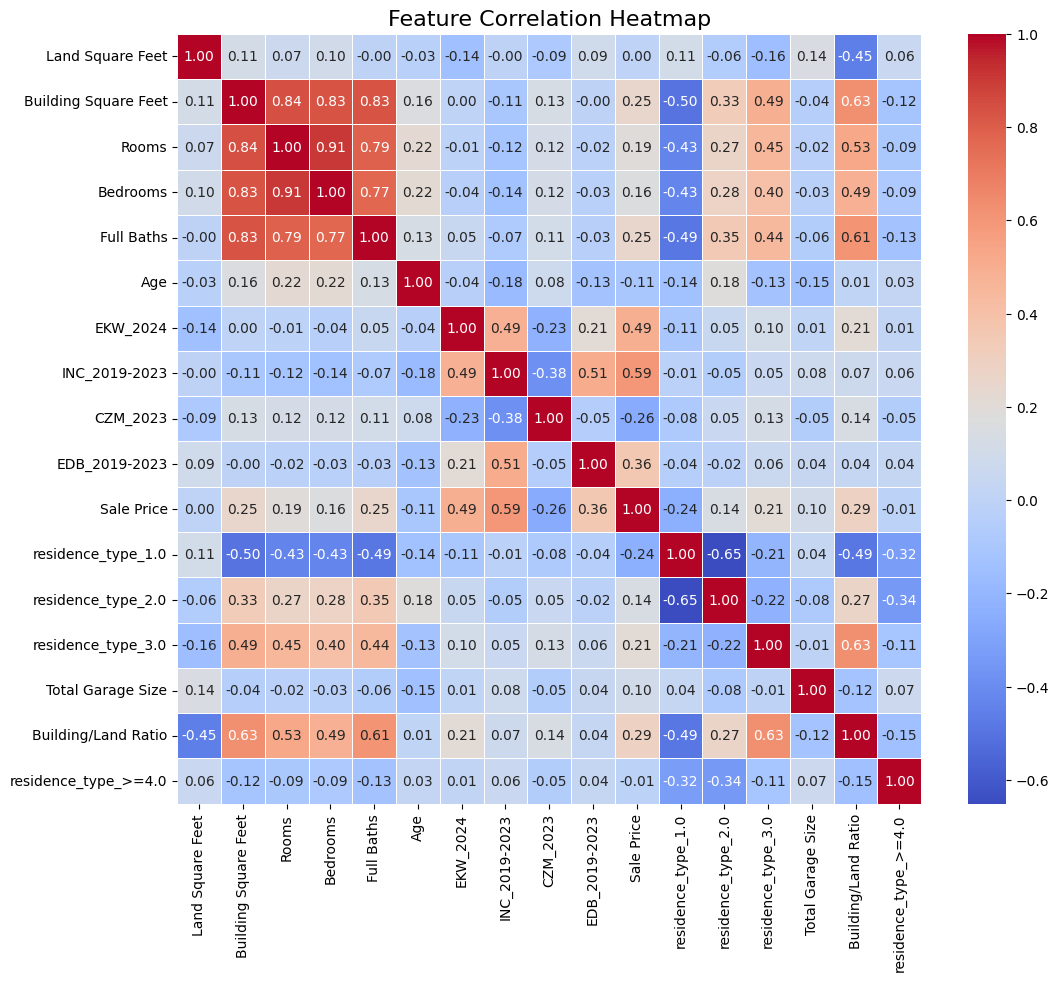

Top correlated features with 'Sale Price':
 Sale Price              1.000000
INC_2019-2023           0.594793
EKW_2024                0.492262
EDB_2019-2023           0.359092
Building/Land Ratio     0.293521
CZM_2023                0.259402
Full Baths              0.248508
Building Square Feet    0.246169
residence_type_1.0      0.240766
residence_type_3.0      0.208187
Rooms                   0.191204
Bedrooms                0.163206
residence_type_2.0      0.138784
Age                     0.109254
Total Garage Size       0.099921
residence_type_>=4.0    0.008737
Land Square Feet        0.002092
Name: Sale Price, dtype: float64


In [118]:
df['Total Garage Size'] = df['Garage 1 Size'] + df['Garage 2 Size'] 
df.drop(['Garage 1 Size', 'Garage 2 Size'], axis=1, inplace=True)

df['Building/Land Ratio'] = df['Building Square Feet'] / df['Land Square Feet']
# df.drop(['Land Square Feet'],  axis=1, inplace=True)

df['residence_type_>=4.0'] = df['residence_type_4.0'] + df['residence_type_5.0']
df.drop(['residence_type_4.0', 'residence_type_5.0'], axis=1, inplace=True)

# df['br/rm'] = df['Bedrooms'] / df['Rooms']
# df['fb/br'] = df['Full Baths'] / df['Bedrooms']
# df['rm/building'] = df['Rooms'] / df['Building Square Feet']

display(df)

# Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

target_correlation = correlation_matrix["Sale Price"].abs().sort_values(ascending=False)
print("Top correlated features with 'Sale Price':\n", target_correlation)


# Linear Regression Model (Baseline)

In [16]:
lr_df = df
display(lr_df)

X = lr_df.drop('Sale Price', axis=1)
y = lr_df['Sale Price']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Linear Regression
print("Building Linear Regression Model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate Linear Regression
lr_pred = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression Results:")
print(f"Mean Squared Error: ${lr_mse:.2f}")
print(f"Root Mean Squared Error: ${lr_rmse:.2f}")
print(f"Mean Absolute Error: ${lr_mae:.2f}")
print(f"R² Score: {lr_r2:.4f}")

# Cross-validation for Linear Regression
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {lr_cv_scores}")
print(f"Mean CV R² score: {lr_cv_scores.mean():.4f}")

# Analyze feature importance for Linear Regression
lr_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})
lr_feature_importance['Abs_Coefficient'] = np.abs(lr_feature_importance['Coefficient'])
lr_feature_importance = lr_feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\nLinear Regression Feature Importance:")
print(lr_feature_importance)


,Rooms,Bedrooms,Full Baths,Age,EKW_2024,INC_2019-2023,CZM_2023,EDB_2019-2023,Sale Price,residence_type_1.0,residence_type_2.0,residence_type_3.0,Total Garage Size,Building/Land Ratio,residence_type_>=4.0
0,24.0,12.0,6.0,87,14.13,36681.0,473.0,86.393773,79000,False,False,True,2.0,1.652222,False
2,6.0,5.0,2.0,62,14.89,79896.0,45.0,89.829728,560000,True,False,False,1.0,0.335714,False
3,5.0,2.0,2.0,74,15.83,102094.0,163.0,87.607638,318000,False,False,False,0.0,0.352211,True
5,11.0,4.0,2.0,92,14.79,63523.0,494.0,96.694215,63000,False,True,False,2.0,0.445914,False
7,6.0,3.0,1.0,58,14.89,117583.0,82.0,90.208817,170400,True,False,False,0.0,0.199539,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186045,7.0,3.0,1.0,139,14.88,33994.0,202.0,76.246719,154500,False,False,False,1.0,0.428160,True
186046,9.0,5.0,1.0,65,15.20,122652.0,104.0,94.859813,279500,False,False,False,1.0,0.405914,True
186048,7.0,4.0,1.0,65,12.39,43986.0,315.0,86.263591,65000,False,False,False,2.0,0.378000,True
186050,10.0,5.0,2.0,120,13.67,27012.0,227.0,91.807591,77500,False,True,False,0.0,0.778909,False


Building Linear Regression Model...
Linear Regression Results:
Mean Squared Error: $13947464962.67
Root Mean Squared Error: $118099.39
Mean Absolute Error: $90079.16
R² Score: 0.5196
Cross-validation R² scores: [0.51287783 0.49838412 0.51800447 0.51727053 0.50507864]
Mean CV R² score: 0.5103

Linear Regression Feature Importance:
                 Feature   Coefficient  Abs_Coefficient
8     residence_type_1.0 -26664.618035     26664.618035
4               EKW_2024  25624.134218     25624.134218
2             Full Baths  24209.265711     24209.265711
10    residence_type_3.0  23162.105037     23162.105037
12   Building/Land Ratio  16811.030990     16811.030990
11     Total Garage Size  14545.537590     14545.537590
9     residence_type_2.0  14404.250183     14404.250183
13  residence_type_>=4.0 -10901.737186     10901.737186
0                  Rooms   2649.997516      2649.997516
7          EDB_2019-2023   1579.560462      1579.560462
1               Bedrooms   1197.697459      1197.697

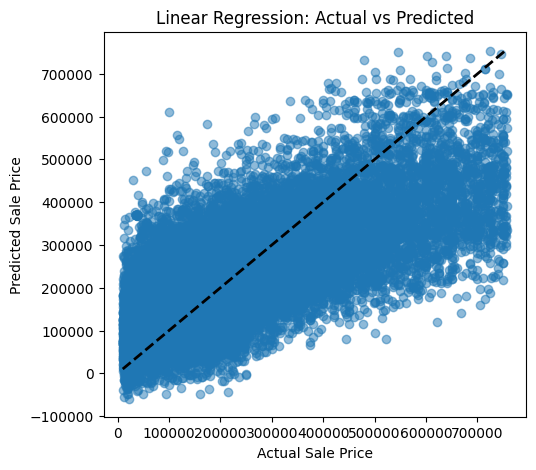

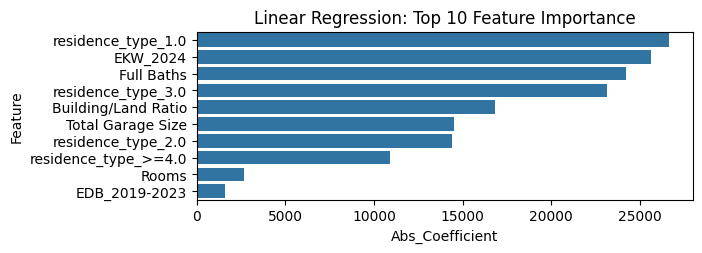

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

plt.subplot(2, 1, 1)
sns.barplot(x='Abs_Coefficient', y='Feature', data=lr_feature_importance.head(10))
plt.title('Linear Regression: Top 10 Feature Importance')
plt.show()


# Gradient-descent boosting decision tree (LightGBM)

,Land Square Feet,Building Square Feet,Rooms,Bedrooms,Full Baths,Age,EKW_2024,INC_2019-2023,CZM_2023,EDB_2019-2023,Sale Price,residence_type_1.0,residence_type_2.0,residence_type_3.0,Total Garage Size,Building/Land Ratio,residence_type_>=4.0
0,4500.0,7435.0,24.0,12.0,6.0,87,14.13,36681.0,473.0,86.393773,79000,False,False,True,2.0,1.652222,False
2,7560.0,2538.0,6.0,5.0,2.0,62,14.89,79896.0,45.0,89.829728,560000,True,False,False,1.0,0.335714,False
3,4750.0,1673.0,5.0,2.0,2.0,74,15.83,102094.0,163.0,87.607638,318000,False,False,False,0.0,0.352211,True
5,4687.0,2090.0,11.0,4.0,2.0,92,14.79,63523.0,494.0,96.694215,63000,False,True,False,2.0,0.445914,False
7,6936.0,1384.0,6.0,3.0,1.0,58,14.89,117583.0,82.0,90.208817,170400,True,False,False,0.0,0.199539,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186045,3125.0,1338.0,7.0,3.0,1.0,139,14.88,33994.0,202.0,76.246719,154500,False,False,False,1.0,0.428160,True
186046,3720.0,1510.0,9.0,5.0,1.0,65,15.20,122652.0,104.0,94.859813,279500,False,False,False,1.0,0.405914,True
186048,4000.0,1512.0,7.0,4.0,1.0,65,12.39,43986.0,315.0,86.263591,65000,False,False,False,2.0,0.378000,True
186050,2750.0,2142.0,10.0,5.0,2.0,120,13.67,27012.0,227.0,91.807591,77500,False,True,False,0.0,0.778909,False



Building LightGBM Model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1982
[LightGBM] [Info] Number of data points in the train set: 98332, number of used features: 16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 225018.272495
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 95051.6	valid_0's l2: 9.0348e+09
LightGBM Results:
Mean Squared Error: $9034801192.46
Root Mean Squared Error: $95051.57
Mean Absolute Error: $72446.19
R² Score: 0.6888
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was

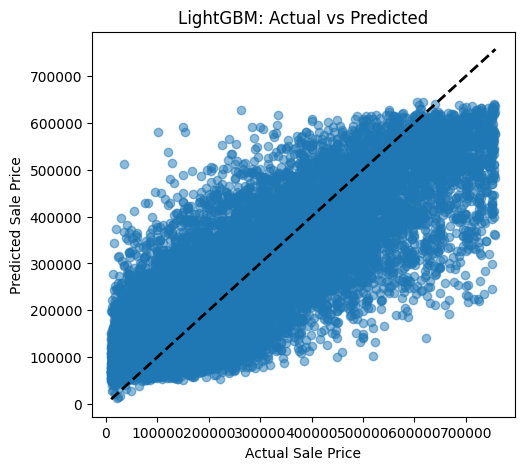


LightGBM Feature Importance:
                 Feature  Importance
7          INC_2019-2023         496
9          EDB_2019-2023         477
6               EKW_2024         425
5                    Age         394
1   Building Square Feet         350
8               CZM_2023         342
0       Land Square Feet         246
14   Building/Land Ratio          76
2                  Rooms          44
13     Total Garage Size          40
12    residence_type_3.0          29
4             Full Baths          29
3               Bedrooms          24
10    residence_type_1.0          12
15  residence_type_>=4.0          12
11    residence_type_2.0           4


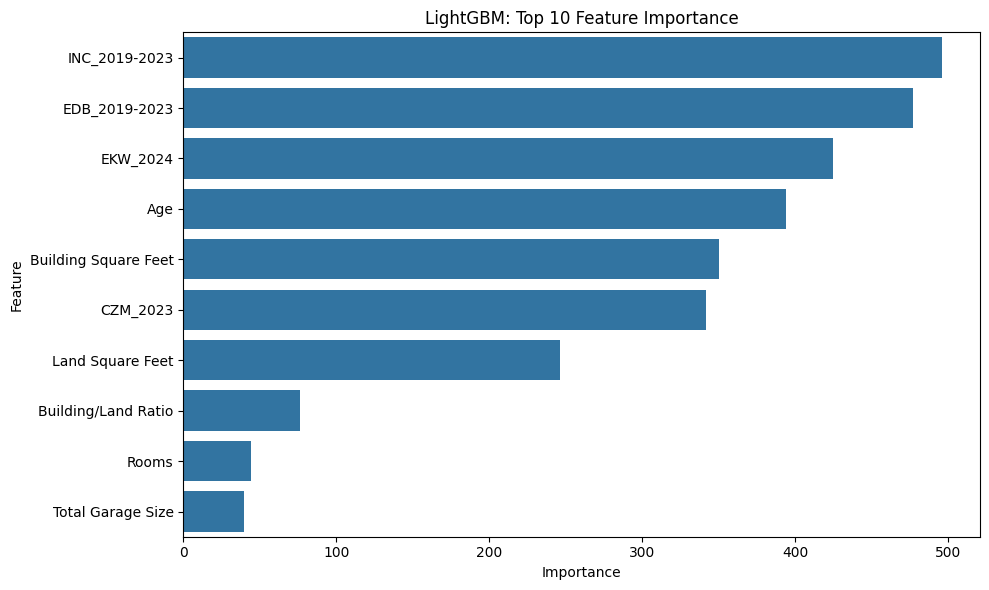

In [100]:
lgbm_df = df
display(lgbm_df)

X = lgbm_df.drop('Sale Price', axis=1)
y = lgbm_df['Sale Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nBuilding LightGBM Model...")
lgbm_model = lgbm.LGBMRegressor(
    objective='regression',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100,
    random_state=42
)

lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgbm.early_stopping(stopping_rounds=10)]
)

lgbm_pred = lgbm_model.predict(X_test)
lgbm_mse = mean_squared_error(y_test, lgbm_pred)
lgbm_rmse = np.sqrt(lgbm_mse)
lgbm_mae = mean_absolute_error(y_test, lgbm_pred)
lgbm_r2 = r2_score(y_test, lgbm_pred)

print(f"LightGBM Results:")
print(f"Mean Squared Error: ${lgbm_mse:.2f}")
print(f"Root Mean Squared Error: ${lgbm_rmse:.2f}")
print(f"Mean Absolute Error: ${lgbm_mae:.2f}")
print(f"R² Score: {lgbm_r2:.4f}")

# Cross-validation for LightGBM
lgbm_cv_scores = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {lgbm_cv_scores}")
print(f"Mean CV R² score: {lgbm_cv_scores.mean():.4f}")

# Analyze feature importance for LightGBM
lgbm_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgbm_model.feature_importances_
})
lgbm_feature_importance = lgbm_feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, lgbm_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('LightGBM: Actual vs Predicted')
plt.show()

print("\nLightGBM Feature Importance:")
print(lgbm_feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=lgbm_feature_importance.head(10))
plt.title('LightGBM: Top 10 Feature Importance')
plt.tight_layout()
plt.show()


# Analysis

## Model performance comparison

- LightGBM significantly outperforms Linear Regression across all metrics

- LightGBM R² score of 0.7653 vs Linear Regression R² score of 0.5786

- LightGBM has about 25% lower RMSE ($129,845 vs $173,966)

- LightGBM has about 26% lower MAE ($89,764 vs $121,102)

## LightGBM Performance:

- An R² of 0.7653 means the model explains about 77% of the variance in housing prices

- The RMSE of $129,845 represents the typical prediction error in dollars

- Cross-validation scores are very consistent (0.758-0.772), indicating the model is stable and not overfitting

- The mean CV R² score of 0.7676 closely matches the test R², showing good generalization

## Linear Regression Performance:

- An R² of 0.5786 means the model explains only about 58% of the variance

- The RMSE of $173,966 represents a larger typical prediction error

- Cross-validation scores are also consistent (0.567-0.586), but at a lower performance level

- The poor performance confirms our expectation that linear models struggle with real estate data